#### Table of contents
- Importing libraries
- Loading datasets
- Feature Engineering
- Cross validation
- Model training
- Model evaluation
- Summary

#### Importing libraries


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import model_selection
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_error,r2_score
from scipy import stats
from sklearn.model_selection import StratifiedKFold
import warnings
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from scipy.stats import boxcox
import os
%matplotlib inline
np.random.seed(365)

#### Loading datasets

In [5]:
#load datasets
data_path_train = r"C:\Users\User\Desktop\Blessing_AI\Free_AI_Classes_2023\Data\Housing_dataset_train.csv"
df_train = pd.read_csv(data_path_train)

data_path_test = r"C:\Users\User\Desktop\Blessing_AI\Free_AI_Classes_2023\Data\Housing_dataset_test.csv"
df_test = pd.read_csv(data_path_test)

#### Feature Engineering

##### Filling missing values

In [6]:
#Dropping missing values in selected features
df_train.dropna(subset=["loc","title","bedroom"],inplace=True)
df_train.shape

(8856, 7)

In [7]:

def group_feature_by_feature_based_on_mode(by_feature,feature,df):
    modes_values = []
    titles = list(df[by_feature].unique())
    for title in titles:
        new_df = df[df[by_feature] == title]
        mode_value =  new_df[feature].mode()[0]
        modes_values.append(mode_value)
    mode_dict = dict(zip(titles, modes_values))
    print(mode_dict)

    return mode_dict
#Fill missing values in bathroon by mode value of house title
mode_values = group_feature_by_feature_based_on_mode(by_feature = "title",feature="bathroom",df=df_train)
#fill missing values by mode house title
def fill_missing_by_mode(cols,mode_dict=mode_values):
    col1 = cols[0]
    col2 = cols[1]
    if pd.isnull(col2):
        return mode_dict[col1]
    else:
        return col2


df_train["bathroom"] = df_train[["title","bathroom"]].apply(fill_missing_by_mode,axis = 1)

#Fill missing values in parking by mode value of house titl
mode_values = group_feature_by_feature_based_on_mode(by_feature = "title",feature="parking_space",df=df_train)
df_train["parking_space"] = df_train[["title","parking_space"]].apply(fill_missing_by_mode,axis = 1)

print(f"Total missing data in train data is {df_train.isnull().sum().sum()}")
print(f"Total missing data in test data  is {df_test.isnull().sum().sum()}")

{'Semi-detached duplex': 2.0, 'Detached duplex': 1.0, 'Penthouse': 2.0, 'Bungalow': 2.0, 'Apartment': 1.0, 'Terrace duplex': 1.0, 'Townhouse': 1.0, 'Mansion': 1.0, 'Flat': 2.0, 'Cottage': 1.0}
{'Semi-detached duplex': 3.0, 'Detached duplex': 3.0, 'Penthouse': 4.0, 'Bungalow': 4.0, 'Apartment': 4.0, 'Terrace duplex': 4.0, 'Townhouse': 1.0, 'Mansion': 1.0, 'Flat': 2.0, 'Cottage': 1.0}
Total missing data in train data is 0
Total missing data in test data  is 0


##### Creating new features

In [8]:
#create new feature to inducate geopolitical zone
geo_states = {"North_central":["Benue","Kogi", "Kwara", "Nasarawa", "Niger", "Plateau"],
"North_East":["Adamawa", "Bauchi", "Borno", "Gombe", "Taraba", "Yobe"],
"North_West":["Kaduna", "Katsina", "Kano", "Kebbi", "Sokoto", "Jigawa","Zamfara"],
"South_East":["Abia", "Anambra", "Ebonyi", "Enugu", "Imo"],
"South":["Akwa Ibom", "Bayelsa", "Cross River", "Delta", "Edo", "Rivers"],
"South_West":["Ekiti", "Lagos", "Osun", "Ondo", "Ogun", "Oyo"]}

def add_geo_zone(df_train):
        df_train["Geo_zone"] = df_train["loc"]
        df_train.loc[df_train["loc"].isin(geo_states["North_central"]),"Geo_zone"] = "North_central"
        df_train.loc[df_train["loc"].isin(geo_states["North_East"]),"Geo_zone"] = "North_East"
        df_train.loc[df_train["loc"].isin(geo_states["North_West"]),"Geo_zone"] = "North_West"
        df_train.loc[df_train["loc"].isin(geo_states["South_East"]),"Geo_zone"] = "South_East"
        df_train.loc[df_train["loc"].isin(geo_states["South"]),"Geo_zone"] = "South"
        df_train.loc[df_train["loc"].isin(geo_states["South_West"]),"Geo_zone"] = "South_West"
        return df_train
df_train = add_geo_zone(df_train = df_train)

##### Encoding categorical features

In [9]:
#squaring and logging output feature
df_train["price_log"] = np.log(df_train["price"] + 1)
df_train["price_sqrt"] = np.sqrt(df_train["price"])

In [10]:
#Encode house location based mean houe price ranking
#avergae pricing based on location
location_ranks = list(df_train.groupby(["loc"])["price"].mean().sort_values(ascending=False).index)
location_ranks_dict = {}
for i in location_ranks:
    location_ranks_dict[i] = location_ranks.index(i) + 1
print(location_ranks_dict)
# Use the map() function to encode the data
categories_train = df_train["loc"]
categories_test = df_test["loc"]
encoded_data_train = categories_train.map(location_ranks_dict)
encoded_data_test = categories_test.map(location_ranks_dict)
df_train["loc"] = encoded_data_train

{'Lagos': 1, 'Bayelsa': 2, 'Rivers': 3, 'Akwa Ibom': 4, 'Delta': 5, 'Ogun': 6, 'Cross River': 7, 'Anambra': 8, 'Oyo': 9, 'Edo': 10, 'Enugu': 11, 'Ondo': 12, 'Osun': 13, 'Ekiti': 14, 'Kano': 15, 'Nasarawa': 16, 'Imo': 17, 'Katsina': 18, 'Plateau': 19, 'Benue': 20, 'Adamawa': 21, 'Kwara': 22, 'Niger': 23, 'Kaduna': 24, 'Gombe': 25, 'Taraba': 26, 'Kogi': 27, 'Bauchi': 28, 'Yobe': 29, 'Jigawa': 30, 'Abia': 31, 'Borno': 32, 'Zamfara': 33, 'Sokoto': 34, 'Kebbi': 35, 'Ebonyi': 36}


In [43]:
#Encode house location based mean houe price ranking
#avergae pricing based on location
location_ranks = list(df_train.groupby(["title"])["price"].mean().sort_values(ascending=False).index)
location_ranks_dict = {}
for i in location_ranks:
    location_ranks_dict[i] = location_ranks.index(i) + 1

print(location_ranks_dict)
# Use the map() function to encode the data
categories_train = df_train["title"]
categories_test = df_test["title"]
encoded_data_train = categories_train.map(location_ranks_dict)
encoded_data_test = categories_test.map(location_ranks_dict)
df_train["title"] = encoded_data_train

{'Mansion': 1, 'Penthouse': 2, 'Detached duplex': 3, 'Unknown': 4, 'Townhouse': 5, 'Terrace duplex': 6, 'Semi-detached duplex': 7, 'Bungalow': 8, 'Flat': 9, 'Apartment': 10, 'Cottage': 11}


In [44]:
#Encode house geopolotical zone  based mean houe price ranking
#avergae pricing based on title
location_ranks = list(df_train.groupby(["Geo_zone"])["price"].mean().sort_values(ascending=False).index)
location_ranks_dict = {}
for i in location_ranks:
    location_ranks_dict[i] = location_ranks.index(i) + 1
print(location_ranks_dict)
# Use the map() function to encode the data
categories_train = df_train["Geo_zone"]
encoded_data_train = categories_train.map(location_ranks_dict)
df_train["Geo_zone"] = encoded_data_train

{'South': 1, 'South_West': 2, 'Unknown': 3, 'South_East': 4, 'North_central': 5, 'North_East': 6, 'North_West': 7}


In [45]:
#Converting bedroom,bathroom and parking space to discrete variables
df_train[["bedroom","bathroom","parking_space"]] = df_train[["bedroom","bathroom","parking_space"]].astype(int)
df_test[["bedroom","bathroom","parking_space"]] = df_test[["bedroom","bathroom","parking_space"]].astype(int)
df_train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price,Geo_zone,price_log,price_sqrt
0,3583,19,7,2,2,1,1149999.565,7,13.955273,1072.380327
1,2748,11,10,1,2,4,1672416.689,2,14.329781,1293.219505
2,9261,15,4,7,5,2,3364799.814,2,15.028879,1834.339067
3,2224,8,3,5,2,4,2410306.756,4,14.695265,1552.516266
4,10300,29,6,1,5,6,2600700.898,5,14.771292,1612.668874


In [46]:
#Adding total number of bedrooms,bathrooms and parking space
df_train["bed_bath_paking"] =  df_train["bedroom"] + df_train["bathroom"] + df_train["parking_space"]
df_test["bed_bath_paking"] =  df_test["bedroom"] + df_test["bathroom"] + df_test["parking_space"]

#### Cross Validation

In [49]:
#dictionary of models to be used
models = {"Linear_Regression":LinearRegression(),
          "Random_Forest":RandomForestRegressor(random_state=0),"XGboost":xgb.XGBRegressor(random_state=0),
          "Catboost":CatBoostRegressor(random_state=0,silent=True),"Gradient_boosting":GradientBoostingRegressor(random_state=0)}

#Calculate the number of bins using the Sturges method
bins = int(np.ceil(np.log2(len(df_train)) + 1))
#Bin the data using the Sturges method
binned_data = pd.cut(df_train["price"], bins=bins,labels=False)
df_train["Bin_value"] = binned_data

#Divid data into dependent and independent variables
X = df_train.drop(["Bin_value","price","price_log","ID","price_sqrt"],axis=1)
y = df_train["Bin_value"]
target = "price_log"
#skf = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

#Custom cross validation function
def run(models):
    #create empty dic for model and scores
    scores = {}
    for model in models.keys():
        scores[model] = [] #create empty lsit to store model scores at on each fold
    for name,model in models.items():
        print(f"Running -- {name}")
        print("-------------------------")
        for i,(train_index, test_index) in enumerate(skf.split(X, y)):
            xtrain, xvalid = X.iloc[train_index], X.iloc[test_index]
            ytrain, yvalid = df_train[target].iloc[train_index], df_train[target].iloc[test_index]
            model.fit(xtrain, ytrain)
            yvalid = np.exp(yvalid) - 1
            #make predictions on validation data
            preds_valid =  np.exp(model.predict(xvalid)) -1
            rmse = mean_squared_error(yvalid, preds_valid,squared=False)
            print(f"Fold {i} score : ", rmse)
            scores[name].append(rmse)
        print(f"{model} -- mean rmse {np.mean(scores[name])}")
        print()

    #take the mean of scores for every model
    for name, model in models.items():
        scores[name] = np.mean(np.array(scores[name]))
    model_names = scores.keys()
    model_scores = scores.values()
    results = {"Model":model_names,"Rmse_score":model_scores}
    results = pd.DataFrame.from_dict(results) #create dictionary of model and corresponding mean rmse score
    return results

In [50]:
results = run(models = models)

Running -- Linear_Regression
-------------------------
Fold 0 score :  672365.0482334284
Fold 1 score :  659569.4882421744
Fold 2 score :  663019.814060372
Fold 3 score :  689962.0846617826
Fold 4 score :  683470.9811140407
Fold 5 score :  677756.1085147084
Fold 6 score :  688451.3732423781
Fold 7 score :  669106.8144500032
Fold 8 score :  736291.0143240849
Fold 9 score :  735560.6236546115
LinearRegression() -- mean rmse 687555.3350497584

Running -- Random_Forest
-------------------------
Fold 0 score :  638413.8994211911
Fold 1 score :  523460.57968888927
Fold 2 score :  598448.5131817762
Fold 3 score :  603657.4798439238
Fold 4 score :  628132.3878249043
Fold 5 score :  567013.2614946527
Fold 6 score :  614438.3000945566
Fold 7 score :  590526.5155155818
Fold 8 score :  657957.4870324606
Fold 9 score :  555875.6422062557
RandomForestRegressor(random_state=0) -- mean rmse 597792.4066304192

Running -- XGboost
-------------------------
Fold 0 score :  595913.7834545614
Fold 1 score :

In [52]:
sorted_df = results.sort_values(by="Rmse_score",ascending=True)
sorted_df.head()

,Model,Rmse_score
4,Gradient_boosting,552989.412159
3,Catboost,555607.047884
2,XGboost,565757.634637
1,Random_Forest,597792.406630
0,Linear_Regression,687555.335050


Comment : Gradient performs best compared t other models

In [53]:
#save results
path = r"C:\Users\User\Desktop\Blessing_AI\Free_AI_Classes_2023\Results"
os.chdir(path)
sorted_df.to_csv("model_results.csv",index=False)

#### Model Training
-Training best model - Gradient boosting

In [19]:
#split data into train and test
X = df_train.drop(["price","price_log","ID","price_sqrt"],axis=1)
y = df_train["price_log"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#train model
gb_model = GradientBoostingRegressor(random_state=0)
gb_model.fit(X_train,y_train)

GradientBoostingRegressor(random_state=0)

### Model Evaluation

In [20]:
y_preds = np.exp(gb_model.predict(X_test) - 1)
print(y_preds)

[ 640658.77456769  889431.16218719  382662.38967687 ... 1012349.44880857
  479942.04129494  625789.3509273 ]


In [21]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_preds))

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_preds)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_preds)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Root Mean Squared Error (RMSE): 846106.1822115304
Mean Squared Error (MSE): 715895671576.5714
Mean Absolute Error (MAE): 774657.2650989096


### Model Intepretations

Feature importance method

In [22]:
#get feature importance from model
feature_importances = gb_model.feature_importances_

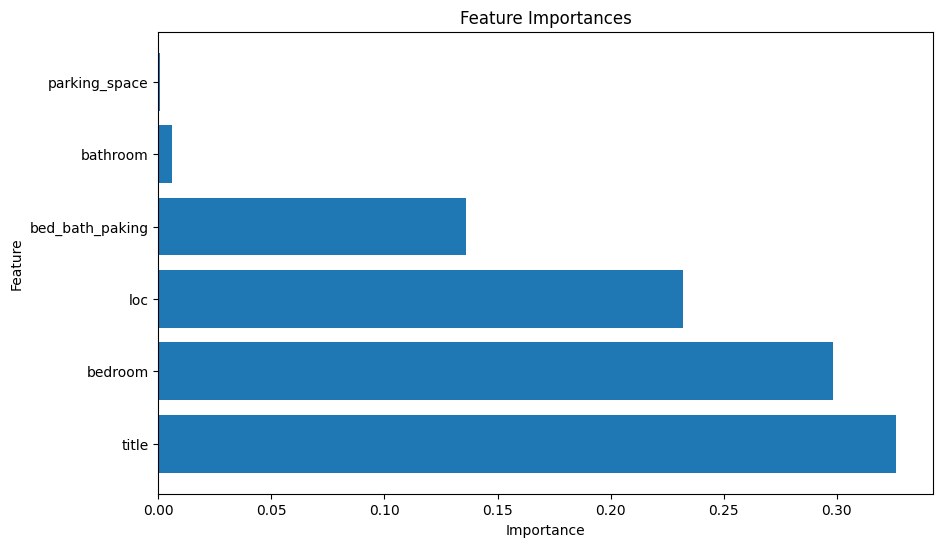

In [23]:
# Create a DataFrame to store the feature names and importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

Comment : The feature importance from the model shows that title , number of bedrooms,location ,sum of bedroom plus bathroom plus parking are the most significant for local interpretation of the model

In [ ]:
# Create an explainer object for your model
explainer = shap.Explainer(model)

# Calculate SHAP values for a subset of your data (e.g., X_test)
shap_values = explainer.shap_values(X_test)

In [ ]:
# Plot a summary plot to see feature importances for a specific prediction (e.g., the first prediction)
shap.summary_plot(shap_values[1], X_test.iloc[0])

# Alternatively, you can use force plot to visualize individual predictions
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])